<a href="https://colab.research.google.com/github/maximmillion/ConvolutionExp/blob/main/GLCM_synthetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import History 

from random import randint
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import cv2

from skimage.filters import gaussian
from skimage.util import random_noise
import matplotlib.pyplot as pp

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

from tensorflow.keras import datasets, layers, models
from xgboost import XGBClassifier
%matplotlib inline

# Making the dataset:

In [ ]:
# Create 250 squares
NUM_SQUARES = 250
WIDTH = 128

X_train = []
for i in range(NUM_SQUARES):
    exp = np.zeros((WIDTH, WIDTH)) #  128*128 canvas 
    x_start = randint(0, WIDTH - 1)
    x_end = randint(x_start, WIDTH)
    y_start = randint(0, WIDTH - 1)
    y_end = randint(y_start, WIDTH)
    for x in range(y_start, y_end):
        for y in range(y_start, y_end):
            exp[x, y] = 1
    X_train.append(exp)

In [ ]:
# Create 250 circles
for i in range(NUM_SQUARES):
    x = np.arange(0, WIDTH)
    y = np.arange(0, WIDTH)
    arr = np.zeros((y.size, x.size))

    cx = randint(0, WIDTH)
    cy = randint(0, WIDTH)
    r = randint(0, WIDTH / 2)

    # The two lines below could be merged, but I stored the mask
    # for code clarity.
    mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < r**2
    arr[mask] = 1
    if randint(0, 1) == 0: # sometie true
        arr = np.fliplr(arr)
    X_train.append(arr)
print(len(X_train))

500


In [ ]:
Y_train = np.array([1 if i < NUM_SQUARES else 0 for i in range(NUM_SQUARES * 2)])

In [ ]:
# Shuffle training data
shuffler = np.random.permutation(NUM_SQUARES*2)

X_train = np.array(X_train)

x_train = X_train[shuffler].astype(np.uint8)
y_train = Y_train[shuffler]

0


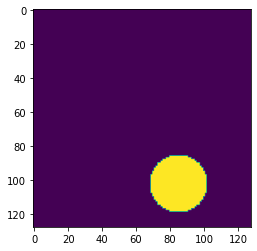

In [ ]:
print(y_train[101])
plt.imshow(x_train[101])

# GLCM Feature extraction:

In [ ]:
from skimage.feature import greycomatrix, greycoprops

x_features = []

for img in tqdm(x_train):
    features = []
    for size in [1, 3, 5]:
        for angle in [0, np.pi/4, np.pi/2, 3*np.pi/4]:
            GLCM = greycomatrix(img, [size], [angle])
            features.extend(greycoprops(GLCM, 'energy')[0])
            features.extend(greycoprops(GLCM, 'correlation')[0])
            features.extend(greycoprops(GLCM, 'dissimilarity')[0])
            features.extend(greycoprops(GLCM, 'homogeneity')[0])
            features.extend(greycoprops(GLCM, 'contrast')[0])
    x_features.append(features)

100%|██████████| 500/500 [00:16<00:00, 30.40it/s]


In [ ]:
x_features = np.array(x_features)
x_features.shape

(500, 60)

# Splitting:

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_features, y_train,
                                                    stratify=y_train, 
                                                    test_size=0.2)
results = {}

In [ ]:
print(x_train.shape)
print(x_test.shape)

(400, 60)
(100, 60)


# Applying models:

## Light GBM:

In [ ]:
#!pip install lightgbm
import lightgbm as lgb

d_train = lgb.Dataset(x_train, label=y_train)

# https://lightgbm.readthedocs.io/en/latest/Parameters.html
lgbm_params = {'learning_rate':0.05, 'boosting_type':'dart',    
              'objective':'multiclass',
              'metric': 'multi_logloss',
              'num_leaves':100,
              'max_depth':10,
              'num_class':4}  #no.of unique values in the target class not inclusive of the end value


lgb_model = lgb.train(lgbm_params, d_train, 100) #50 iterations. Increase iterations for small learning rates

# Predict the response for test dataset
y_pred = lgb_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred)
results['lgb'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 60
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
def showconfusionmatrix(cm):
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.show()

[[29 21]
 [ 6 44]]


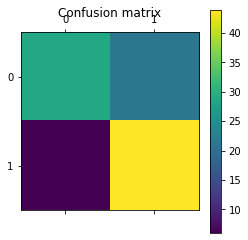

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## SVM

In [ ]:
# Train the Linear SVM
from sklearn.svm import LinearSVC

clf = LinearSVC(max_iter=10000)

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['SVM'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.6

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        50
           1       0.60      0.60      0.60        50

    accuracy                           0.60       100
   macro avg       0.60      0.60      0.60       100
weighted avg       0.60      0.60      0.60       100



[[30 20]
 [20 30]]


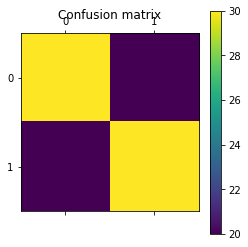

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## Random Forest:

In [ ]:
# creating a random forest
clf =  RandomForestClassifier(n_estimators = 100, random_state=30)

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['random_forest'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.8

              precision    recall  f1-score   support

           0       0.88      0.70      0.78        50
           1       0.75      0.90      0.82        50

    accuracy                           0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100



[[35 15]
 [ 5 45]]


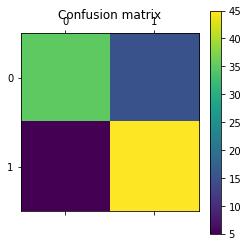

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## Decision Tree:

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['decision_tree'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.81

              precision    recall  f1-score   support

           0       0.92      0.68      0.78        50
           1       0.75      0.94      0.83        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[[34 16]
 [ 3 47]]


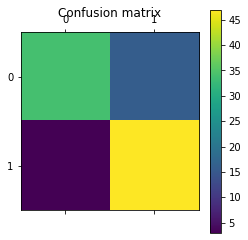

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

[Text(242.0396907216495, 211.7178947368421, 'X[36] <= 0.98\ngini = 0.5\nsamples = 400\nvalue = [200, 200]'),
 Text(183.79484536082475, 200.2736842105263, 'X[10] <= 0.99\ngini = 0.456\nsamples = 298\nvalue = [105, 193]'),
 Text(112.17525773195877, 188.82947368421054, 'X[16] <= 0.977\ngini = 0.485\nsamples = 228\nvalue = [94, 134]'),
 Text(72.48247422680413, 177.38526315789474, 'X[41] <= 0.971\ngini = 0.498\nsamples = 182\nvalue = [85, 97]'),
 Text(37.96701030927835, 165.94105263157894, 'X[4] <= 0.005\ngini = 0.47\nsamples = 122\nvalue = [46, 76]'),
 Text(24.16082474226804, 154.49684210526317, 'X[1] <= 0.922\ngini = 0.45\nsamples = 114\nvalue = [39, 75]'),
 Text(17.25773195876289, 143.05263157894737, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(31.0639175257732, 143.05263157894737, 'X[15] <= 0.945\ngini = 0.429\nsamples = 109\nvalue = [34, 75]'),
 Text(13.80618556701031, 131.60842105263157, 'X[41] <= 0.965\ngini = 0.153\nsamples = 24\nvalue = [2, 22]'),
 Text(6.903092783505155, 120.

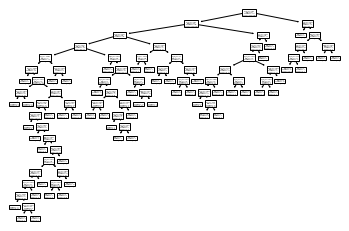

In [ ]:
# plot tree
from sklearn import tree

tree.plot_tree(clf)

## AdaBoost Classifier:

In [ ]:
# Create Adaboostclassifier
clf = AdaBoostClassifier(n_estimators=42)

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['ada_boost'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.61

              precision    recall  f1-score   support

           0       0.66      0.46      0.54        50
           1       0.58      0.76      0.66        50

    accuracy                           0.61       100
   macro avg       0.62      0.61      0.60       100
weighted avg       0.62      0.61      0.60       100



[[23 27]
 [12 38]]


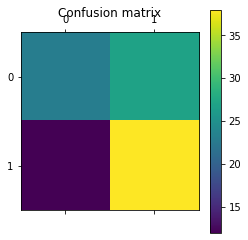

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## XG Boost Classifier:

In [ ]:
# Create XG boost classifer object
clf = XGBClassifier()

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['xg_boost'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

/home/ahsanyleg/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:35:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.8

              precision    recall  f1-score   support

           0       0.86      0.72      0.78        50
           1       0.76      0.88      0.81        50

    accuracy                           0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100



[[36 14]
 [ 6 44]]


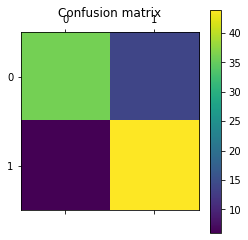

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## Gaussian Naive Bayes:

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Create Gaussian Naive Bayes Classifier
clf = GaussianNB()

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['gauss_NB'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.58

              precision    recall  f1-score   support

           0       0.56      0.72      0.63        50
           1       0.61      0.44      0.51        50

    accuracy                           0.58       100
   macro avg       0.59      0.58      0.57       100
weighted avg       0.59      0.58      0.57       100



[[36 14]
 [28 22]]


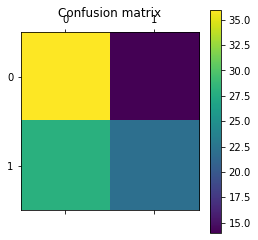

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## Logistic Regression:

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression Classifier
clf = LogisticRegression(solver='liblinear')

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['log_regression'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.62

              precision    recall  f1-score   support

           0       0.61      0.66      0.63        50
           1       0.63      0.58      0.60        50

    accuracy                           0.62       100
   macro avg       0.62      0.62      0.62       100
weighted avg       0.62      0.62      0.62       100



[[33 17]
 [21 29]]


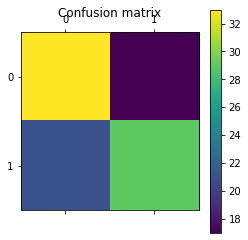

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

# Plotting the results:

<BarContainer object of 8 artists>

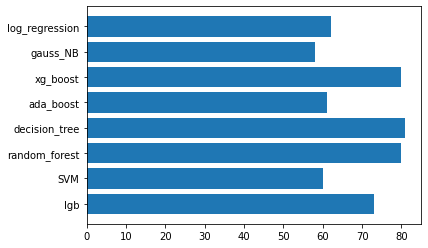

In [ ]:
plt.barh(list(results.keys()), results.values())

In [ ]:
results

{'lgb': 73.0,
 'SVM': 60.0,
 'random_forest': 80.0,
 'decision_tree': 81.0,
 'ada_boost': 61.0,
 'xg_boost': 80.0,
 'gauss_NB': 58.0,
 'log_regression': 62.0}